*Goal*: 
1. find out if the dataset fits the data requirements
2. get interactions dataframe ['user_id', 'item_id', 'date'(%Y-%m), 'timetsamp']
2. get item meta dataframe ['item_id', meta_col('genre_id' or 'tag_id', etc...)]

*Ideal Data Requirements*:
* user activity is >80% of all time intervals
* month 1, user has >5 rates
* month 0, to pre-train model
* items are comparable
* timestamp
* implicit feedback
* ranking problem


*Conclusion*:

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
import pandas as pd 
import re
import numpy as np

from data_utils import getDF, getDF_n_lines, load_data
from dataset_evaluation_utils import * 

from datetime import datetime, timezone
import gzip
import json

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# import plotly.offline as py
# pd.options.plotting.backend = "plotly"
# py.init_notebook_mode() # graphs charts inline (IPython).

a4_dims = (11.7, 8.27)

# paths

In [3]:
dataset_folderpath = '../datasets/goodreads/'

dataset_name = 'Goodreads'
dump_foldername ='goodreads_dump/'

# rule: what/which_data_set/sample_version/what/
images_path, output_path, heatmaps_path, diversity_graphpath, diversity_filepath = get_folderpaths(dump_foldername)

images/goodreads_dump/heatmaps/
images/goodreads_dump/diversity_eval/


___

# Goodreads

https://mengtingwan.github.io/data/goodreads#datasets

## column names

In [4]:
inter_columns = ['user_id', 'item_id', 'date','timestamp']
# meta_col = ''
# item_meta_columns = ['item_id', meta_col]

In [8]:
user_col = 'user_id'
item_col = 'book_id'
date_col = 'date'
inter_dedup_columns = ['user_id','book_id', 'is_read','is_reviewed', 'timestamp', 'date']

____
# to skip, no need to run these

In [ ]:
# # takes 5min on my pc
# orig_df = pd.read_csv(dataset_folderpath+'goodreads_interactions.csv')
# orig_df


# snipet of datasets

In [ ]:
# orig_df

In [ ]:
# load_data(dataset_folderpath+'goodreads_interactions_dedup.json.gz', head=3)

In [ ]:
# load_data(dataset_folderpath+'goodreads_book_authors.json.gz', head=3)

In [ ]:
# load_data(dataset_folderpath+'goodreads_book_genres_initial.json.gz', head=3)

In [ ]:
# load_data(dataset_folderpath+'goodreads_book_series.json.gz', head=3)

In [ ]:
# load_data(dataset_folderpath+'goodreads_book_works.json.gz', head=3)

In [ ]:
# load_data(dataset_folderpath+'goodreads_books.json.gz', head=3)

In [ ]:
# load_data(dataset_folderpath+'goodreads_reviews_spoiler.json.gz', head=3)

# get interactions df

In [ ]:
# getDF_n_lines(dataset_folderpath+'goodreads_interactions_dedup.json.gz', head=3)
# # inter_dedup = getDF(dataset_folderpath+'goodreads_interactions_dedup.json.gz') # 170min running and didn't finish

In [ ]:
# '''
#     Stats of the 1st *head* number of lines of the goodreads_interactions_dedup file
#     code inspired https://github.com/MengtingWan/goodreads/blob/master/reviews.ipynb
# '''
# time_format = '%a %b %d %H:%M:%S %z %Y'
# head = 100000 
# fn = dataset_folderpath+'goodreads_interactions_dedup.json.gz'
# print('counting file:', fn)

# n_lines, n_isread, n_pos_rates, n_empty_reviews, n_review_updates_spaced_min_1d, n_readat_dates = 0, 0, 0, 0, 0, 0
# book_set, user_set, review_set, user_book_set = set(), set(), set(), set()
# # n_lines, n_sentence, n_spoiler_review, n_spoiler_sentence = 0, 0, 0, 0
# # book_set, user_set = set(), set()
# print('current line: ', end='')
# with gzip.open(fn) as fin:
#     for l in fin:
#         d = json.loads(l)

#         if (head is not None) and (n_lines > head):
#             break
        
#         if n_lines % 1000000 == 0:
#             print(n_lines, end=',')
#         n_lines += 1

#         n_isread += 1 if d['is_read'] else 0
#         n_pos_rates += 1 if d['rating'] > 4 else 0
#         n_empty_reviews +=1 if d['review_text_incomplete']=='' else 0

#         delta = datetime.strptime(d['date_updated'], time_format) - datetime.strptime(d['date_added'], time_format)
#         n_review_updates_spaced_min_1d += 1 if abs(delta.days) > 1 else 0

#         n_readat_dates += 1 if d['read_at'] != '' else 0

#         book_set.add(d['book_id'])
#         user_set.add(d['user_id'])
#         review_set.add(d['review_id'])
#         user_book_set.add((d['user_id'], d['book_id']))

# print('complete')
# print('done!')
# print('number of lines ',n_lines)
# print('number of books flagged as read ',n_isread, n_isread/n_lines)
# print('number of positive rates (5 stars) ',n_pos_rates, n_pos_rates/n_lines)
# print('number of empty reviews ',n_empty_reviews, n_empty_reviews/n_lines)
# print('number of reviews updated after more than 1 day ',n_review_updates_spaced_min_1d, n_review_updates_spaced_min_1d/n_lines)
# print('number of values in read_at column ',n_readat_dates, n_readat_dates/n_lines)
# print('number of books ',len(book_set), len(book_set)/n_lines)
# print('number of users ',len(user_set), len(user_set)/n_lines)
# print('number of reviews ',len(review_set), len(review_set)/n_lines)
# print('number of user_alpha-book_A reviews ',len(user_book_set), len(user_book_set)/n_lines)
# # print(n_lines, n_isread, n_pos_rates, n_empty_reviews, n_review_updates_spaced_min_1d, n_readat_dates, len(book_set), len(user_set), len(review_set))


# # results:
# # counting file: ../datasets/goodreads/goodreads_interactions_dedup.json.gz
# # current line: 0,complete
# # done!
# # number of lines  100001
# # number of books flagged as read  46876 0.4687553124468755
# # number of positive rates (5 stars)  14056 0.14055859441405585
# # number of empty reviews  91709 0.9170808291917081
# # number of reviews updated after more than 1 day  23348 0.23347766522334776
# # number of values in read_at column  20742 0.20741792582074178
# # number of books  59158 0.5915740842591574
# # number of users  228 0.0022799772002279977
# # number of reviews  100001 1.0
# # number of user_alpha-book_A reviews  100001 1.0


In [ ]:
# inter_columns

# load_interactions_to_dict

In [ ]:
# # pos_rates_folderpath = output_path+'pos_rates_only/'
# # validate_folderpath(pos_rates_folderpath)

# # time_format = '%a %b %d %H:%M:%S %z %Y'
# # head = int(100000/0.14)  # 100k has 14% of positive rates, but i want all
# # fn = dataset_folderpath+'goodreads_interactions_dedup.json.gz'


# def load_interactions_to_dict(head:int, rating:int, save_folder:str, save_filename:str, file_foldername:str):
#     '''
#         Loads the positive ratings interactions of 'goodreads_interactions_dedup.json.gz' file to a dict
#         Prints some stats of the filtered interactions
        
#         head: int, number of lines to read
#         rating: int, positive rates will be those above it
#     '''

#     validate_folderpath(save_folder)

#     print('counting file:', file_foldername)

#     time_format='%a %b %d %H:%M:%S %z %Y'
    
#     n_lines, n_pos_rates = 0, 0
#     book_set, user_set = set(), set()

#     inter_dedup_dict = {}

#     print('current line: ', end='')
#     with gzip.open(file_foldername) as fin:
#         for l in fin:
#             d = json.loads(l)

#             if (head is not None) and (n_lines > head):
#                 break
            
#             if n_lines % 100000 == 0:
#                 print(n_lines, end=',')
#             n_lines += 1

#             # only positive ratings, 4 and 5 stars
#             if d['rating'] > rating:
#                 n_pos_rates += 1
                
#                 date = datetime.strptime(d['date_added'], time_format)
#                 date = datetime.strptime(str(date.year)+'-'+str(date.month), '%Y-%m' )
#                 ts = datetime.timestamp(date)

#                 is_reviewed = 1 if d['review_text_incomplete']!='' else 0 

#                 book_set.add(d['book_id'])
#                 user_set.add(d['user_id'])

#                 inter_dedup_dict[n_lines] = [d['user_id'], d['book_id'], d['is_read'], is_reviewed, ts, date]


#     joblib.dump(inter_dedup_dict, save_folder+save_filename+'_dict.joblib')

#     print('complete')
#     print('done!')
#     print('number of lines ',n_lines)
#     print('number of positive rates (>'+str(rating)+' stars) ',n_pos_rates, n_pos_rates/n_lines)
#     print('number of books ',len(book_set), len(book_set)/n_lines)
#     print('number of users ',len(user_set), len(user_set)/n_lines)

#     return inter_dedup_dict

In [ ]:
# # Code before creating the function

# # pos_rates_folderpath = output_path+'pos_rates_only/'
# # validate_folderpath(pos_rates_folderpath)

# # time_format = '%a %b %d %H:%M:%S %z %Y'
# # head = int(100000/0.14)  # 100k has 14% of positive rates, but i want all
# # stars = 3

# # fn = dataset_folderpath+'goodreads_interactions_dedup.json.gz'

# # print('counting file:', fn)

# # n_lines, n_pos_rates = 0, 0
# # book_set, user_set = set(), set()

# # inter_dedup_dict = {}

# # print('current line: ', end='')
# # with gzip.open(fn) as fin:
# #     for l in fin:
# #         d = json.loads(l)

# #         if (head is not None) and (n_lines > head):
# #             break
        
# #         if n_lines % 100000 == 0:
# #             print(n_lines, end=',')
# #         n_lines += 1

# #         # only positive ratings, 4 and 5 stars
# #         if d['rating'] > stars:
# #             n_pos_rates += 1
            
# #             date = datetime.strptime(d['date_added'], time_format)
# #             date = datetime.strptime(str(date.year)+'-'+str(date.month), '%Y-%m' )
# #             ts = datetime.timestamp(date)

# #             is_reviewed = 1 if d['review_text_incomplete']!='' else 0 

# #             book_set.add(d['book_id'])
# #             user_set.add(d['user_id'])

# #             inter_dedup_dict[n_lines] = [d['user_id'], d['book_id'], d['is_read'], is_reviewed, ts, date]


# # joblib.dump(inter_dedup_dict, pos_rates_folderpath+'inter_dedup_dict_+'+str(stars)+'stars.joblib')

# # print('complete')
# # print('done!')
# # print('number of lines ',n_lines)
# # print('number of positive rates (>'+str(stars)+' stars)',n_pos_rates, n_pos_rates/n_lines)
# # print('number of books ',len(book_set), len(book_set)/n_lines)
# # print('number of users ',len(user_set), len(user_set)/n_lines)

# save_folder=output_path+'pos_rates_only/'
# save_filename='inter_dedup_+3stars'

# inter_dedup_dict  = load_interactions_to_dict(head= int(100000/0.14), # 100k has 14% of positive rates, but i want all... c:
#                                                 rating =  3,
#                                                 save_folder=save_folder, 
#                                                 save_filename=save_filename,
#                                                 file_foldername=dataset_folderpath+'goodreads_interactions_dedup.json.gz')

# positive interactions dataframe

In [ ]:
# pos_inter = pd.DataFrame.from_dict(inter_dedup_dict, orient='index',columns=inter_dedup_columns)
# pos_inter.head()

In [ ]:
# pos_inter.to_csv(save_folder+save_filename+'_df.csv')

In [ ]:
# pos_inter.date.max()

In [ ]:
# pos_inter.date.min()

In [ ]:
# dataset_name

In [ ]:
# pos_inter[[user_col, date_col]]\
#         .groupby(date_col)\
#             .count().sort_values(by=['date'], ascending=[True]).plot(title='how many interactions per month');

In [ ]:
# df_1315, _, _, _ = sample_time_period(['2013-01','2015-01'], pos_inter, col=user_col, time_col=date_col)
# df_1315.head()

not enough interactions per semester (aka >10k/bucket)

In [ ]:
# _dict  = load_interactions_to_dict(head=int(100000/0.14)*4,
#                                       rating=3,
#                                       save_folder=output_path+'pos_rates_only/', 
#                                       save_filename='inter_dedup_+3stars_4x714k',
#                                       file_foldername=dataset_folderpath+'goodreads_interactions_dedup.json.gz')
# _df = pd.DataFrame.from_dict(_dict, orient='index',columns=inter_dedup_columns)

In [ ]:
# _df[[user_col, date_col]]\
#         .groupby(date_col)\
#             .count().sort_values(by=['date'], ascending=[True]).plot(title='how many interactions per month');

In [ ]:
# _, _, _, _ = sample_time_period(['2013-01','2015-01'], _df, col=user_col, time_col=date_col)

# end of "to skip, no need to run these"
_____

run all from now on 

# load_interactions_within_period_to_dict

In [5]:
def load_interactions_within_period_to_dict(head, rating, period, save_folder, save_filename, file_foldername, time_format='%a %b %d %H:%M:%S %z %Y'):
    '''
        Loads the positive ratings interactions, within the given period, of 'goodreads_interactions_dedup.json.gz' file to a dict
        Prints some stats of the filtered interactions
        
        head: int, number of lines to read
        rating: int, positive rates will be those above it
    '''

    validate_folderpath(save_folder)

    print('counting file:', file_foldername)

    # start_year, end_year = period
    time_period = [(period[0], '%Y-%m'), (period[1], '%Y-%m')]
    start_ym, end_ym = datetime.strptime(*time_period[0]), datetime.strptime(*time_period[1])

    n_lines, n_pos_rates = 0, 0
    book_set, user_set = set(), set()

    inter_dedup_dict = {}

    print('current line: ', end='')
    with gzip.open(file_foldername) as fin:
        for l in fin:
            d = json.loads(l)

            if (head is not None) and (n_lines > head):
                break
            
            if n_lines % 100000 == 0:
                print(n_lines, end=',')
            n_lines += 1
            
            date = datetime.strptime(d['date_added'], time_format)
            year_month = datetime.strptime( str(date.year)+'-'+str(date.month), '%Y-%m' )
            # if (date.year >= start_year) & (date.year <= end_year): 
            if start_ym <= year_month < end_ym:
                # only positive ratings, 4 and 5 stars
                if d['rating'] > rating:
                    n_pos_rates += 1
                    
                    # date = datetime.strptime(d['date_added'], time_format)
                    date = datetime.strptime(str(date.year)+'-'+str(date.month), '%Y-%m' )
                    ts = datetime.timestamp(date)

                    is_reviewed = 1 if d['review_text_incomplete']!='' else 0 

                    book_set.add(d['book_id'])
                    user_set.add(d['user_id'])

                    inter_dedup_dict[n_lines] = [d['user_id'], d['book_id'], d['is_read'], is_reviewed, ts, date]


    joblib.dump(inter_dedup_dict, save_folder+save_filename+'_dict.joblib')

    print('complete')
    print('done!')
    print('number of lines ',n_lines)
    print('number of positive rates (>'+str(rating)+' stars) ',n_pos_rates, n_pos_rates/n_lines)
    print('number of books ',len(book_set), len(book_set)/n_lines)
    print('number of users ',len(user_set), len(user_set)/n_lines)

    return inter_dedup_dict

In [6]:
int(100000/0.14)*4

2857140

In [9]:
inter_dedup_columns

['user_id', 'book_id', 'is_read', 'is_reviewed', 'timestamp', 'date']

# sample ['2012-07', '2015-01'[ 

counting file: ../datasets/goodreads/goodreads_interactions_dedup.json.gz
current line: 0,100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000,1500000,1600000,1700000,1800000,1900000,2000000,2100000,2200000,2300000,2400000,2500000,2600000,2700000,2800000,complete
done!
number of lines  2857141
number of positive rates (>3 stars)  386800 0.1353800879970572
number of books  128545 0.04499077924400651
number of users  5176 0.0018116011775407654


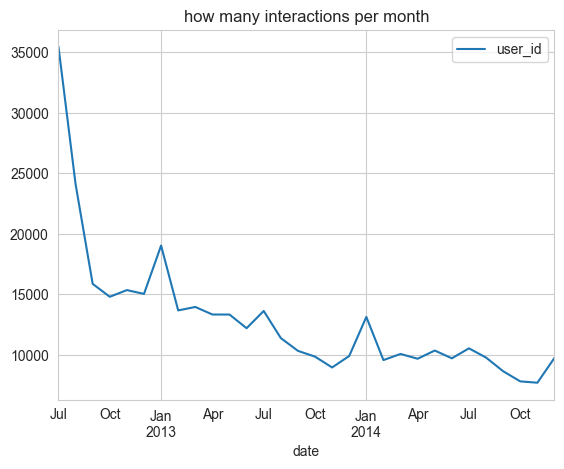

In [10]:
period=['2012-07', '2015-01'] # ['2012-07', '2015-01'[ 
sample = 'sample_'+str(period[0])+'_until_'+str(period[1])
save_folder = output_path+'pos_rates_only/'+sample+'/'
filename = 'inter_dedup_coldstart_3stars_4x714k'

interd_2  = load_interactions_within_period_to_dict(head=int(100000/0.14)*4,
                                      rating=3,
                                      period=period,
                                      save_folder=save_folder, 
                                      save_filename=filename,
                                      file_foldername=dataset_folderpath+'goodreads_interactions_dedup.json.gz')
pos_inter_2 = pd.DataFrame.from_dict(interd_2, orient='index',columns=inter_dedup_columns)
pos_inter_2[[user_col, date_col]]\
        .groupby(date_col)\
            .count().sort_values(by=['date'], ascending=[True]).plot(title='how many interactions per month');

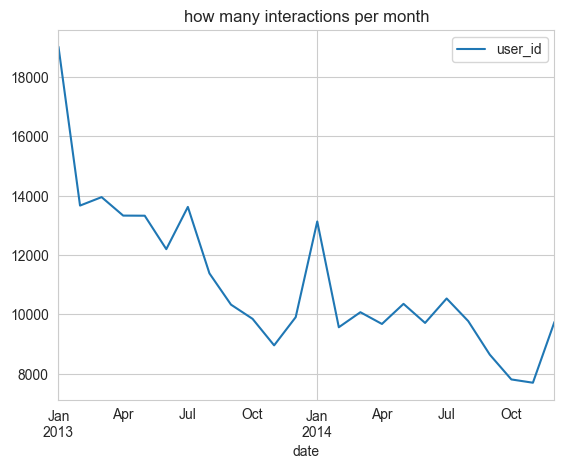

In [11]:
ym = datetime.strptime('2012-12', '%Y-%m' )
pos_inter_2.loc[pos_inter_2[date_col]>ym,[user_col, date_col]]\
        .groupby(date_col)\
            .count().sort_values(by=['date'], ascending=[True]).plot(title='how many interactions per month');

In [12]:
print(save_folder)
print(filename)

output/goodreads_dump/pos_rates_only/sample_2012-07_until_2015-01/
inter_dedup_coldstart_3stars_4x714k


In [ ]:
pos_inter_2.to_csv(save_folder+filename+'_df.csv')

## stats on the sampled dataframe

In [13]:
pos_inter_2.head()

,user_id,book_id,is_read,is_reviewed,timestamp,date
216,8842281e1d1347389f2ab93d60773d4d,1969280,True,0,1.414814e+09,2014-11-01
217,8842281e1d1347389f2ab93d60773d4d,17290220,True,1,1.414814e+09,2014-11-01
219,8842281e1d1347389f2ab93d60773d4d,6882,True,0,1.412136e+09,2014-10-01
220,8842281e1d1347389f2ab93d60773d4d,6954929,True,1,1.412136e+09,2014-10-01
224,8842281e1d1347389f2ab93d60773d4d,18176747,True,1,1.412136e+09,2014-10-01


In [14]:
pos_inter_2['is_read'].value_counts() # Great! ^o^

True    386800
Name: is_read, dtype: int64

In [15]:
pos_inter_2['is_reviewed'].value_counts() # in writting

0    320218
1     66582
Name: is_reviewed, dtype: int64

In [ ]:
pos_inter_2.drop(columns=['is_read','is_reviewed']).to_csv(save_folder+filename+'_interactions_df.csv')

# get_interactions_info

In [ ]:
period

In [16]:
# bc the 1st semester will be for cold start purposes, the time period sample is starting on 2013
# (the frequent users are calculated from after 2013 and only those users' interactions will go to holdouts)
# the frequent users
# posint_1314, _, _, _ = sample_time_period(['2013-01','2015-01'], pos_inter_2, col=user_col, time_col=date_col)

user_presence_df, user_month_interactions, \
    trimestres, user_trimestre_interactions, \
        semesters, user_semester_interactions = get_interactions_info(pos_inter_2, user_col, quarter_info=True, semester_info=True)

0.0 %
25.0 %
50.0 %
75.0 %


In [17]:
user_presence_df

,UserID,month_%,trimestre_%,semestre_%
0,fcf087290b8c3f96a442f858809bf6ef,1.000000,1.0,1.0
1,ddc44923909c38b4d149a38431105943,1.000000,1.0,1.0
2,4067184200f3f78ed31283724f2d989b,1.000000,1.0,1.0
3,d36a167d9d05249418d8d7d821cdc3ce,1.000000,1.0,1.0
4,004f6d189c4546a39db2162986c0d9e1,1.000000,1.0,1.0
...,...,...,...,...
5171,3de96e48c122b764292b0d33dc0e091a,0.033333,0.1,0.2
5172,5dc9e143945eb66177b90ffb07a3578b,0.033333,0.1,0.2
5173,3cb38531c6aab7bcae3c26455b763fe6,0.033333,0.1,0.2
5174,e615589eff78e18438d412729f5f28c0,0.033333,0.1,0.2


In [18]:
semesters

[(Timestamp('2012-07-01 00:00:00'),
  Timestamp('2012-12-31 00:00:00', freq='6M')),
 (Timestamp('2013-01-01 00:00:00'),
  Timestamp('2013-06-30 00:00:00', freq='6M')),
 (Timestamp('2013-07-01 00:00:00'),
  Timestamp('2013-12-31 00:00:00', freq='6M')),
 (Timestamp('2014-01-01 00:00:00'),
  Timestamp('2014-06-30 00:00:00', freq='6M'))]

In [19]:
print(save_folder)
print(sample)
print(filename)

output/goodreads_dump/pos_rates_only/sample_2012-07_until_2015-01/
sample_2012-07_until_2015-01
inter_dedup_coldstart_3stars_4x714k


In [ ]:
joblib.dump(user_presence_df, save_folder+filename+'_user_presence_df.joblib')
joblib.dump(user_month_interactions, save_folder+filename+'_user_month_interactions.joblib')
joblib.dump(trimestres, save_folder+filename+'_trimestres.joblib')
joblib.dump(user_trimestre_interactions, save_folder+filename+'_user_trimestre_interactions.joblib')
joblib.dump(semesters, save_folder+filename+'_semesters.joblib')
joblib.dump(user_semester_interactions, save_folder+filename+'_user_semester_interactions.joblib')

thr=0.8


frequent_users = get_frequent_users(user_presence_df, frequency_threshold=thr)
joblib.dump(frequent_users, save_folder+filename+'_frequent_users_'+str(thr)+'.joblib') # has all 3 in one file

# frequent_users_month,\
#     frequent_users_trimester,\
#         frequent_users_semester = get_frequent_users(user_presence_df, frequency_threshold=thr)
# joblib.dump(frequent_users_month, save_folder+filename+'_frequent_users_month'+str(thr)+'.joblib')
# joblib.dump(frequent_users_trimester, save_folder+filename+'_frequent_users_trimester'+str(thr)+'.joblib')
# joblib.dump(frequent_users_semester, save_folder+filename+'_frequent_users_semester'+str(thr)+'.joblib')

In [ ]:
len(frequent_users)

In [ ]:
frequent_users

In [ ]:
user_semester_interactions

# get users that are frequent on the *train set*

In [20]:
semesters_idx=[1,2,3,4]
n_semester_thr=3
frequent_users_1314_semester_interactions = get_semester_info_with_user_thresh(print_timeperiod='2013 and 2014',
                                                                                  usi=user_semester_interactions,
                                                                                  semesters_idx=semesters_idx,
                                                                                  n_semester_thr=n_semester_thr)

frequent_users_1314_semester_interactions

3323 users of 5176 (64.2001545595054%) are in 75.0% or more semesters in 2013 and 2014 (41433.0 interactions)

Number of interactions per semester in 2013 and 2014:
 1    10733.0
2    10497.0
3    10460.0
4     9743.0
dtype: float64


,1,2,3,4
1c827fa2ab834e37e6158992d5323ce4,4.0,2.0,2.0,4.0
5e1d38f0c4a308364fec6276ef022620,5.0,3.0,5.0,3.0
0838dda3480fa85f414734cf40d81c25,4.0,3.0,5.0,2.0
5e3a44146a0889537c5fa777b6ff7bf4,4.0,6.0,3.0,0.0
b5f937e40b9cb0e2eecb4ba2365e2019,6.0,6.0,6.0,6.0
...,...,...,...,...
c2023420f0b0cea5cbf1c1408b148d7d,0.0,1.0,3.0,4.0
ed76f424843b3da7bebf34e93beb9dfe,0.0,1.0,1.0,1.0
125a1c7aa92551935661469e5a3868a9,0.0,1.0,5.0,4.0
ecd6a89229ea8ad5ffda725091ee99e4,0.0,1.0,3.0,5.0


looks good!

In [21]:
frequent_users_1314 = frequent_users_1314_semester_interactions.index.to_list()
frequent_users_1314[:5]

['1c827fa2ab834e37e6158992d5323ce4',
 '5e1d38f0c4a308364fec6276ef022620',
 '0838dda3480fa85f414734cf40d81c25',
 '5e3a44146a0889537c5fa777b6ff7bf4',
 'b5f937e40b9cb0e2eecb4ba2365e2019']

In [22]:
# get frequent user interactions from the cold start bucket
f = user_semester_interactions.index.isin(frequent_users_1314)
cold_start_semester_interactions = user_semester_interactions.loc[f, 0]
cold_start_semester_interactions

1c827fa2ab834e37e6158992d5323ce4    5.0
5e1d38f0c4a308364fec6276ef022620    3.0
0838dda3480fa85f414734cf40d81c25    2.0
5e3a44146a0889537c5fa777b6ff7bf4    6.0
b5f937e40b9cb0e2eecb4ba2365e2019    6.0
                                   ... 
c2023420f0b0cea5cbf1c1408b148d7d    0.0
ed76f424843b3da7bebf34e93beb9dfe    0.0
125a1c7aa92551935661469e5a3868a9    0.0
ecd6a89229ea8ad5ffda725091ee99e4    0.0
df9aed0c5ba3bd4c73c388c650357958    0.0
Name: 0, Length: 3323, dtype: float64

In [25]:
# add frequent user interactions from the cold start bucket to frame
frequent_users_1314_semester_interactions.insert(0, 0, cold_start_semester_interactions)
frequent_users_1314_semester_interactions

,0,1,2,3,4
1c827fa2ab834e37e6158992d5323ce4,5.0,4.0,2.0,2.0,4.0
5e1d38f0c4a308364fec6276ef022620,3.0,5.0,3.0,5.0,3.0
0838dda3480fa85f414734cf40d81c25,2.0,4.0,3.0,5.0,2.0
5e3a44146a0889537c5fa777b6ff7bf4,6.0,4.0,6.0,3.0,0.0
b5f937e40b9cb0e2eecb4ba2365e2019,6.0,6.0,6.0,6.0,6.0
...,...,...,...,...,...
c2023420f0b0cea5cbf1c1408b148d7d,0.0,0.0,1.0,3.0,4.0
ed76f424843b3da7bebf34e93beb9dfe,0.0,0.0,1.0,1.0,1.0
125a1c7aa92551935661469e5a3868a9,0.0,0.0,1.0,5.0,4.0
ecd6a89229ea8ad5ffda725091ee99e4,0.0,0.0,1.0,3.0,5.0


In [ ]:
# fu_1314_semesters = semesters # cold start + sample (it's the same bc the initial sample was already cold start + 2y)
# fu_1314_semesters

In [23]:
thr = n_semester_thr/len(semesters_idx) # 4 semesters -> 2 years 
sample_fu_1314 = 'fu_'+str(thr)

In [28]:
save_folder+filename+'_'+sample_fu_1314+'_user_semester_interactions.joblib'

'output/goodreads_dump/pos_rates_only/sample_2012-07_until_2015-01/inter_dedup_coldstart_3stars_4x714k_fu_0.75_user_semestre_interactions.joblib'

In [31]:
# joblib.dump(frequent_users_1314_semester_interactions, save_folder+filename+'_fu_'+str(n_semester_thr/len(semesters_idx))+'_user_semester_interactions.joblib')

# joblib.dump(fu_1314_semesters, output_path+filename+'_'+sample_fu_1314+'_semestres.joblib')
joblib.dump([None, None, frequent_users_1314], save_folder+filename+'_frequent_users_'+str(thr)+'.joblib')
joblib.dump(frequent_users_1314_semester_interactions, save_folder+filename+'_'+sample_fu_1314+'_user_semester_interactions.joblib')

['output/goodreads_dump/pos_rates_only/sample_2012-07_until_2015-01/inter_dedup_coldstart_3stars_4x714k_fu_0.75_user_semester_interactions.joblib']

# get all genres

___
## proof code works

In [ ]:
# _ = pd.json_normalize(load_data(dataset_folderpath+'goodreads_book_genres_initial.json.gz', head=1000))
# _

In [ ]:
# _.columns

In [ ]:
# 'genres.history, historical fiction, biography'[len('genres.'):].split(', ')

In [ ]:
# _list = [c[len('genres.'):].split(', ') for c in _.columns[1:]]
# import itertools
# merged = list(itertools.chain(*_list))
# merged

In [ ]:
# [c[len('genres.'):] for c in _.columns[1:]]

end of code proof
___

# book genres

In [ ]:
book_genres = pd.json_normalize(load_data(dataset_folderpath+'goodreads_book_genres_initial.json.gz', head=None))
book_genres

In [ ]:
item_meta_list = [c[len('genres.'):] for c in book_genres.columns[1:]]
item_meta_list

In [ ]:
print(output_path)
print(save_folder)

In [ ]:
len(item_meta_list)

In [ ]:
joblib.dump(item_meta_list, output_path+'item_meta_list.joblib')

In [ ]:
book_genres_clean = book_genres.replace(to_replace=np.NaN, value=0)
book_genres_clean

In [ ]:
genre_count = book_genres.drop(columns=['book_id']).count(axis=1)
book_genres_clean['genre_count'] = genre_count

In [ ]:
book_genres_clean.columns = ['book_id'] + item_meta_list + ['genre_count']
book_genres_clean

In [ ]:
book_genres_clean['book_id'].nunique()

## save to csv

In [ ]:
book_genres_clean.to_csv(output_path+'item_meta_df.csv')

# one column book genres

In [ ]:
book_genres_onecol = getDF(dataset_folderpath+'goodreads_book_genres_initial.json.gz')
book_genres_onecol['genres_list'] = book_genres_onecol['genres'].apply(lambda x: list(x.keys()))
book_genres_onecol

In [ ]:
book_genres_onecol_clean = book_genres_onecol[['book_id','genres_list']].explode('genres_list')
book_genres_onecol_clean

In [ ]:
book_genres_onecol_clean = pd.merge(book_genres_onecol_clean, book_genres_clean[['book_id', 'genre_count']])
book_genres_onecol_clean

## save to csv

In [ ]:
book_genres_onecol_clean.to_csv(output_path+'item_meta_onecol_df.csv')

In [ ]:
print('how many books have x amount of genres:\n', book_genres_clean['genre_count'].value_counts()/book_genres_clean['book_id'].nunique())#.value_counts()

17% does not have any genres

In [ ]:
book_genres_clean.loc[book_genres_clean['genre_count']==10,:]

In [ ]:
#incompatible_genres = [('fiction', 'non-fiction')] ? 
# if someone labeled it as biography, could have also labled it as non-fiction, 
# but in the same train of thought, if someone labled it historical fiction, then could also have labled it as fiction

In [ ]:
pd.qcut(book_genres_clean['genre_count'], 4, retbins=True, labels=False)